<a href="https://colab.research.google.com/github/sidmahurkar/SemEval-Humor-/blob/master/EDA_humor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import random
import torch
import nltk
from torch import nn
# from torch.utils.data import Dataset, DataLoader, RandomSampler
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from textblob import Word
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import seaborn as sns

In [7]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/semeval_humor_train.csv',encoding='utf-8')
valid_df = pd.read_csv('/content/drive/My Drive/semeval_humor_dev.csv',encoding='utf-8')

In [10]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [11]:
# Counting the number of stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

train_df['stopwords'] = train_df['original'].apply(lambda x: len([x for x in x.split() if x in stop]))
train_df[['original','stopwords']].head()

,original,stopwords
0,France is ‘ hunting down its citizens who join...,5
1,"Pentagon claims 2,000 % increase in Russian tr...",4
2,Iceland PM Calls Snap Vote as Pedophile Furor ...,1
3,"In an apparent first , Iran and Israel <engage...",4
4,Trump was told weeks ago that Flynn misled <Vi...,2


In [12]:
# Counting number of uppercase words 
train_df['upper_count'] = train_df['original'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train_df[['original','upper_count']].head()

,original,upper_count
0,France is ‘ hunting down its citizens who join...,3
1,"Pentagon claims 2,000 % increase in Russian tr...",4
2,Iceland PM Calls Snap Vote as Pedophile Furor ...,10
3,"In an apparent first , Iran and Israel <engage...",3
4,Trump was told weeks ago that Flynn misled <Vi...,4


In [0]:
# Getting the original headline
original = train_df.original.values
edit = train_df.edit.values
edited = []
for i in range(len(train_df)):
  a = original[i].split('<')
  b = original[i].split('>')
  c = a[0] + edit[i] + b[1]
  edited.append(c)

In [76]:
original[3]

'In an apparent first , Iran and Israel <engage/> each other militarily'

In [51]:
edited[2]

'Iceland PM Calls Snap Vote as Pedophile Furor Crashes party '

In [0]:
train_df['edited_headline'] = edited

In [16]:
# getting the grades
grades = train_df.grades.values
grades[0]

10000

In [0]:
a = [int(i) for i in str(grades[0])]

In [18]:
a

[1, 0, 0, 0, 0]

In [0]:
# the length of each original headline
train_df['length_original'] = train_df['original'].apply(len)

In [20]:
train_df.head()

,id,original,edit,grades,meanGrade,stopwords,upper_count,edited_headline,length_original
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,5,3,France is ‘ hunting down its citizens who join...,80
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,4,4,"Pentagon claims 2,000 % increase in Russian tr...",97
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,1,10,Iceland PM Calls Snap Vote as Pedophile Furor ...,67
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,4,3,"In an apparent first , Iran and Israel slap ea...",70
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,2,4,Trump was told weeks ago that Flynn misled sch...,62


In [0]:
# Text Preprocessing for tfidf vectorization
def preprocess(headline):

  stop = stopwords.words('english')
  st = PorterStemmer()
  # stop word removal
  a = " ".join([x for x in headline.split() if x not in stop])
  # Stemming
  a = " ".join([st.stem(word) for word in a.split()])
  # Lemmatization
  a = " ".join([Word(word).lemmatize() for word in a.split()])

  return a

In [22]:
b = preprocess("Therefore, the IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.")
print(b)

therefore, idf word log ratio total number row number row word present.


In [0]:
# for i in range(len(original)):

train_df['processed_original'] = train_df.apply(lambda x: preprocess(x['original']),axis=1)
train_df['processed_edited_headline'] = train_df.apply(lambda x: preprocess(x['edited_headline']),axis=1)

In [24]:
train_df.head()

,id,original,edit,grades,meanGrade,stopwords,upper_count,edited_headline,length_original,processed_original,processed_edited_headline
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,5,3,France is ‘ hunting down its citizens who join...,80,franc ‘ hunt citizen join <isis/> ’ without tr...,franc ‘ hunt citizen join twin ’ without trial...
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,4,4,"Pentagon claims 2,000 % increase in Russian tr...",97,"pentagon claim 2,000 % increas russian troll <...","pentagon claim 2,000 % increas russian troll b..."
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,1,10,Iceland PM Calls Snap Vote as Pedophile Furor ...,67,iceland PM call snap vote pedophil furor crash...,iceland PM call snap vote pedophil furor crash...
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,4,3,"In an apparent first , Iran and Israel slap ea...",70,"In appar first , iran israel <engage/> militarili","In appar first , iran israel slap militarili"
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,2,4,Trump was told weeks ago that Flynn misled sch...,62,trump told week ago flynn misl <vice/> presid .,trump told week ago flynn misl school presid .


In [0]:
# extracting tfidf features
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(train_df['processed_edited_headline'])

In [0]:
# vectorizere = TfidfVectorizer()
# tfidf_train_edited = vectorizer.fit_transform(edited)

In [27]:
tfidf_train.shape

(9652, 7472)

In [28]:
tfidf_train[0]

<1x7472 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [29]:
print(vectorizer.get_feature_names())

['000', '02', '10', '100', '100k', '100m', '101', '103', '104', '106', '10g', '11', '12', '13', '130', '133m', '138', '1380', '14', '140', '15', '16', '168', '17', '18', '180', '19', '190', '192', '1928', '1973', '1984', '199', '1st', '20', '200', '2004', '2005', '2007', '2008', '2009', '2010', '2011', '2013', '2016', '2017', '2018', '2019', '202', '2020', '2024', '2050', '20m', '21', '21st', '22', '227', '230k', '235', '23m', '24', '25', '250', '26b', '27', '28', '29th', '2nd', '30', '300mw', '301', '30th', '31', '34', '35', '36', '361', '37', '38', '39', '40', '400', '41', '418m', '42', '43', '44', '45', '451', '462', '473', '50', '500', '52', '53', '547', '55', '57', '59', '60', '600', '61', '62', '63rd', '64', '65', '666', '67', '69', '70', '700', '75', '76', '77', '773', '78', '80', '81', '82', '83', '84', '85bn', '87', '88', '89', '8g', '90', '900', '9000', '91', '92', '9th', 'aaa', 'aardvark', 'abandon', 'abba', 'abbott', 'abbrevi', 'abe', 'abet', 'abil', 'abl', 'abolish', 'abor

In [0]:
# Getting of pos tags
tokens_edited = []
for sent in edited:
  token = nltk.word_tokenize(sent)
  pos = nltk.pos_tag(token)
  tokens_edited.append(pos)

In [50]:
tokens_edited[2]
# len(tokens_edited)

[('Iceland', 'NNP'),
 ('PM', 'NNP'),
 ('Calls', 'NNP'),
 ('Snap', 'NNP'),
 ('Vote', 'NNP'),
 ('as', 'IN'),
 ('Pedophile', 'NNP'),
 ('Furor', 'NNP'),
 ('Crashes', 'NNP'),
 ('party', 'NN')]

In [53]:
x = TextBlob("Iceland PM Calls Snap Vote as Pedophile Furor Crashes party")
pos_tags = x.tags
pos_tags

[('Iceland', 'NNP'),
 ('PM', 'NNP'),
 ('Calls', 'NNP'),
 ('Snap', 'NNP'),
 ('Vote', 'NNP'),
 ('as', 'IN'),
 ('Pedophile', 'NNP'),
 ('Furor', 'NNP'),
 ('Crashes', 'NNP'),
 ('party', 'NN')]

In [0]:
# Getting unique pos tags of each edited headline
unique_tags = []
for edit in edited:

  tags = []

  a = TextBlob(edit)
  pos_tags = a.tags

  for tag in pos_tags:
    tags.append(tag[1])

  unique_tags.append(list(set(tags)))

In [33]:
unique_tags[2]

['IN', 'NNP', 'NN']

In [34]:
len(unique_tags)

9652

In [0]:
no_of_unique_pos = []
for i in range(len(unique_tags)):
  no_of_unique_pos.append(len(unique_tags[i]))

In [39]:
no_of_unique_pos[2]

3

In [0]:
# Storing the actual word in a list of tags
noun_tags = ['NN','NNP','NNPS','NNS','PRP','PRP$']
adjective_tags = ['JJ','JJR','JJS']
adverb_tags = ['RB','RBR','RBS']
verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']

In [0]:
noun_list = []
adjective_list = []
adverb_list = []
verb_list = []

for edit in edited:

  adj = []
  advb = []
  verb = []

  c = TextBlob(edit)
  pos_tags = c.tags

  for tag in pos_tags:
    if tag[1] in adjective_tags:
      adj.append(tag[0])
    elif tag[1] in adverb_tags:
      advb.append(tag[0])
    elif tag[1] in verb_tags:
      verb.append(tag[0])
  
  noun_list.append(list(set(c.noun_phrases)))
  adjective_list.append(list(set(adj)))
  adverb_list.append(list(set(advb)))
  verb_list.append(list(set(verb)))

In [49]:
print(noun_list[2])
print(adjective_list[2])
print(adverb_list[2])
print(verb_list[2])

['pedophile furor crashes', 'snap vote', 'iceland pm']
[]
[]
[]


In [0]:
# getting the count of each noun,adj,adv,verb tags
no_of_noun = []
no_of_adj = []
no_of_adv = []
no_of_verb = []

for i in range(len(noun_list)):
  a = len(noun_list[i])
  no_of_noun.append(a)

for i in range(len(adjective_list)):
  a = len(adjective_list[i])
  no_of_adj.append(a)

for i in range(len(adverb_list)):
  a = len(adverb_list[i])
  no_of_adv.append(a)

for i in range(len(verb_list)):
  a = len(verb_list[i])
  no_of_verb.append(a)  

In [46]:
no_of_verb[0]

4

In [0]:
train_df['unique_pos_tags'] = no_of_unique_pos

In [0]:
train_df['noun_edited_headline'] = noun_list 
train_df['adj_edited_headline'] = adjective_list 
train_df['advb_edited_headline'] = adverb_list 
train_df['verb_edited_headline'] = verb_list 

In [0]:
train_df['no_of_noun'] = no_of_noun 
train_df['no_of_adj'] = no_of_adj 
train_df['no_of_adv'] = no_of_adv 
train_df['no_of_verb'] = no_of_verb 

In [48]:
train_df.head()

,id,original,edit,grades,meanGrade,stopwords,upper_count,edited_headline,length_original,processed_original,processed_edited_headline,unique_pos_tags,noun_edited_headline,adj_edited_headline,advb_edited_headline,verb_edited_headline,no_of_noun,no_of_adj,no_of_adv,no_of_verb
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,5,3,France is ‘ hunting down its citizens who join...,80,franc ‘ hunt citizen join <isis/> ’ without tr...,franc ‘ hunt citizen join twin ’ without trial...,12,"[iraq, france, twins ’]",[‘],[],"[joined, hunting, is, ’]",3,1,0,4
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,4,4,"Pentagon claims 2,000 % increase in Russian tr...",97,"pentagon claim 2,000 % increas russian troll <...","pentagon claim 2,000 % increas russian troll b...",11,"[pentagon claims, russian, % increase]",[Russian],[],"[mean, bowling, claims, does]",3,1,0,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,1,10,Iceland PM Calls Snap Vote as Pedophile Furor ...,67,iceland PM call snap vote pedophil furor crash...,iceland PM call snap vote pedophil furor crash...,3,"[pedophile furor crashes, snap vote, iceland pm]",[],[],[],3,0,0,0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,4,3,"In an apparent first , Iran and Israel slap ea...",70,"In appar first , iran israel <engage/> militarili","In appar first , iran israel slap militarili",7,"[iran, israel]","[other, apparent, first]",[militarily],[slap],2,3,1,1
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,2,4,Trump was told weeks ago that Flynn misled sch...,62,trump told week ago flynn misl <vice/> presid .,trump told week ago flynn misl school presid .,7,"[school president, flynn, trump]",[],[],"[told, was, misled]",3,0,0,3


In [0]:
# Sentiment Score of each edited headline
def senti_score(headline):
  
  sia = SentimentIntensityAnalyzer()
  edited_headline_sentiment = (sia.polarity_scores(headline))['compound']

  return edited_headline_sentiment

In [0]:
sentiment = []
for i in range(len(edited)):
  score = senti_score(edited[i])
  sentiment.append(score)

In [56]:
sentiment[2]

0.4019

In [0]:
train_df['sentiment_score'] = sentiment

In [0]:
grade = []
for i in range(len(grades)):
  a = [int(i) for i in str(grades[i])]
  grade.append(a)

In [59]:
grade[1]

[3, 3, 1, 1, 0]

In [0]:
# Number of words
num_of_words = []
for i in range(len(original)):
  num_of_words.append(len(original[i].split()))

In [61]:
num_of_words[0]

15

In [0]:
train_df['num_of_words'] = num_of_words

In [63]:
train_df.head()

,id,original,edit,grades,meanGrade,stopwords,upper_count,edited_headline,length_original,processed_original,processed_edited_headline,unique_pos_tags,noun_edited_headline,adj_edited_headline,advb_edited_headline,verb_edited_headline,no_of_noun,no_of_adj,no_of_adv,no_of_verb,sentiment_score,num_of_words
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,5,3,France is ‘ hunting down its citizens who join...,80,franc ‘ hunt citizen join <isis/> ’ without tr...,franc ‘ hunt citizen join twin ’ without trial...,12,"[iraq, france, twins ’]",[‘],[],"[joined, hunting, is, ’]",3,1,0,4,0.0000,15
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,4,4,"Pentagon claims 2,000 % increase in Russian tr...",97,"pentagon claim 2,000 % increas russian troll <...","pentagon claim 2,000 % increas russian troll b...",11,"[pentagon claims, russian, % increase]",[Russian],[],"[mean, bowling, claims, does]",3,1,0,4,-0.0516,17
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,1,10,Iceland PM Calls Snap Vote as Pedophile Furor ...,67,iceland PM call snap vote pedophil furor crash...,iceland PM call snap vote pedophil furor crash...,3,"[pedophile furor crashes, snap vote, iceland pm]",[],[],[],3,0,0,0,0.4019,10
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,4,3,"In an apparent first , Iran and Israel slap ea...",70,"In appar first , iran israel <engage/> militarili","In appar first , iran israel slap militarili",7,"[iran, israel]","[other, apparent, first]",[militarily],[slap],2,3,1,1,0.1531,12
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,2,4,Trump was told weeks ago that Flynn misled sch...,62,trump told week ago flynn misl <vice/> presid .,trump told week ago flynn misl school presid .,7,"[school president, flynn, trump]",[],[],"[told, was, misled]",3,0,0,3,0.0000,11


In [64]:
train_df.describe()

,id,grades,meanGrade,stopwords,upper_count,length_original,unique_pos_tags,no_of_noun,no_of_adj,no_of_adv,no_of_verb,sentiment_score,num_of_words
count,9652.000000,9.652000e+03,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000
mean,7539.845213,2.048111e+11,0.935571,2.196540,5.396809,73.338065,6.863241,3.096560,0.796415,0.255180,1.641214,-0.097542,12.224617
std,4359.342192,8.211835e+12,0.583643,1.757503,4.527129,18.747801,2.255871,1.278291,0.893045,0.532878,1.176151,0.381253,3.664556
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.931300,4.000000
25%,3756.750000,1.110000e+04,0.400000,1.000000,3.000000,61.000000,5.000000,2.000000,0.000000,0.000000,1.000000,-0.401900,10.000000
50%,7510.500000,2.111000e+04,0.800000,2.000000,4.000000,72.000000,7.000000,3.000000,1.000000,0.000000,1.000000,0.000000,12.000000
75%,11325.250000,3.210000e+04,1.400000,3.000000,7.000000,84.000000,8.000000,4.000000,1.000000,0.000000,2.000000,0.000000,14.000000
max,15095.000000,3.333332e+14,3.000000,10.000000,103.000000,146.000000,15.000000,9.000000,6.000000,4.000000,8.000000,0.934900,26.000000


In [65]:
train_df.corr()

,id,grades,meanGrade,stopwords,upper_count,length_original,unique_pos_tags,no_of_noun,no_of_adj,no_of_adv,no_of_verb,sentiment_score,num_of_words
id,1.000000,-0.021443,-0.004100,-0.005541,-0.000741,-0.006169,0.003156,-0.003608,-0.019000,0.000932,0.006185,-0.008802,-0.009210
grades,-0.021443,1.000000,0.026719,-0.002571,-0.016080,-0.012825,-0.003644,-0.018102,0.000962,0.003552,0.000947,0.007752,-0.012739
meanGrade,-0.004100,0.026719,1.000000,0.022047,-0.010275,-0.008564,0.030180,-0.001345,-0.018204,0.012545,0.030906,0.054811,0.015363
stopwords,-0.005541,-0.002571,0.022047,1.000000,-0.282126,0.461455,0.671647,-0.100276,0.175950,0.284773,0.472575,-0.007654,0.570683
upper_count,-0.000741,-0.016080,-0.010275,-0.282126,1.000000,0.199864,-0.221934,0.407128,-0.204783,-0.065344,-0.158498,0.036794,0.221653
length_original,-0.006169,-0.012825,-0.008564,0.461455,0.199864,1.000000,0.541207,0.424735,0.269504,0.197480,0.395987,-0.051137,0.880867
unique_pos_tags,0.003156,-0.003644,0.030180,0.671647,-0.221934,0.541207,1.000000,-0.001493,0.311542,0.375282,0.685429,0.000819,0.640372
no_of_noun,-0.003608,-0.018102,-0.001345,-0.100276,0.407128,0.424735,-0.001493,1.000000,0.062696,-0.032070,-0.038430,-0.030097,0.421038
no_of_adj,-0.019000,0.000962,-0.018204,0.175950,-0.204783,0.269504,0.311542,0.062696,1.000000,0.052350,0.069349,-0.046842,0.229685
no_of_adv,0.000932,0.003552,0.012545,0.284773,-0.065344,0.197480,0.375282,-0.032070,0.052350,1.000000,0.219665,0.012652,0.278984


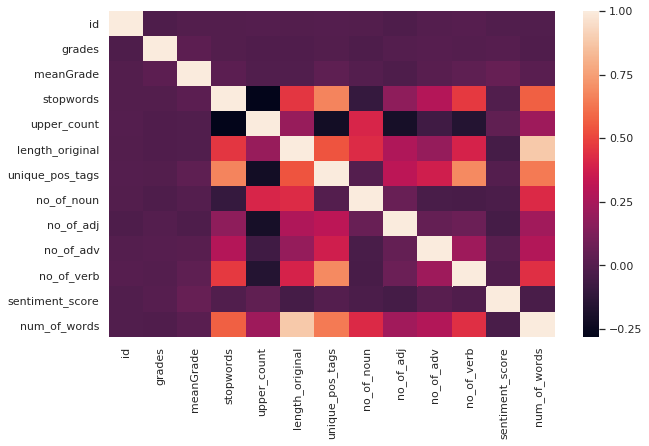

In [69]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
sns.heatmap(train_df.corr())

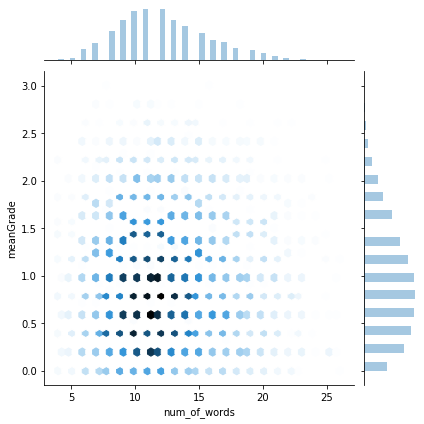

In [67]:
sns.jointplot(x='num_of_words',y='meanGrade',data=train_df,kind='hex')

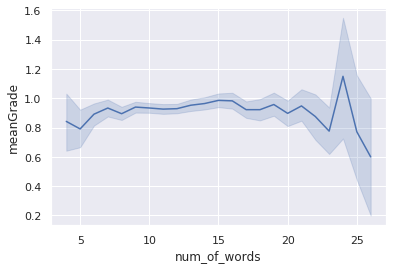

In [70]:
sns.lineplot(x='num_of_words',y='meanGrade',data=train_df)

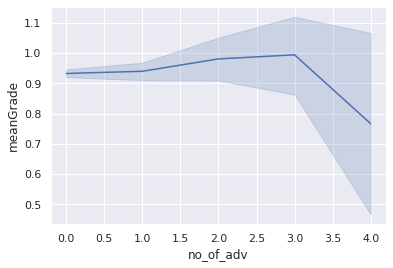

In [71]:
sns.lineplot(x='no_of_adv',y='meanGrade',data=train_df)

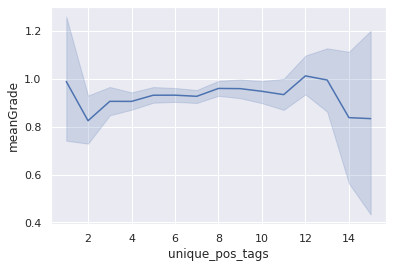

In [72]:
sns.lineplot(x='unique_pos_tags',y='meanGrade',data=train_df)

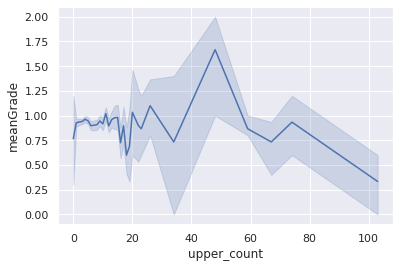

In [75]:
sns.lineplot(x='upper_count',y='meanGrade',data=train_df)

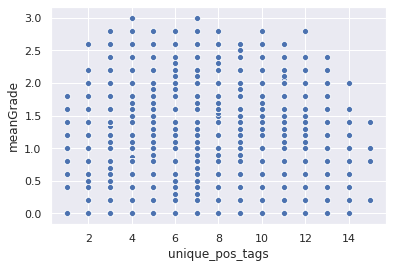

In [73]:
ax = sns.scatterplot(x="unique_pos_tags", y="meanGrade", data=train_df)

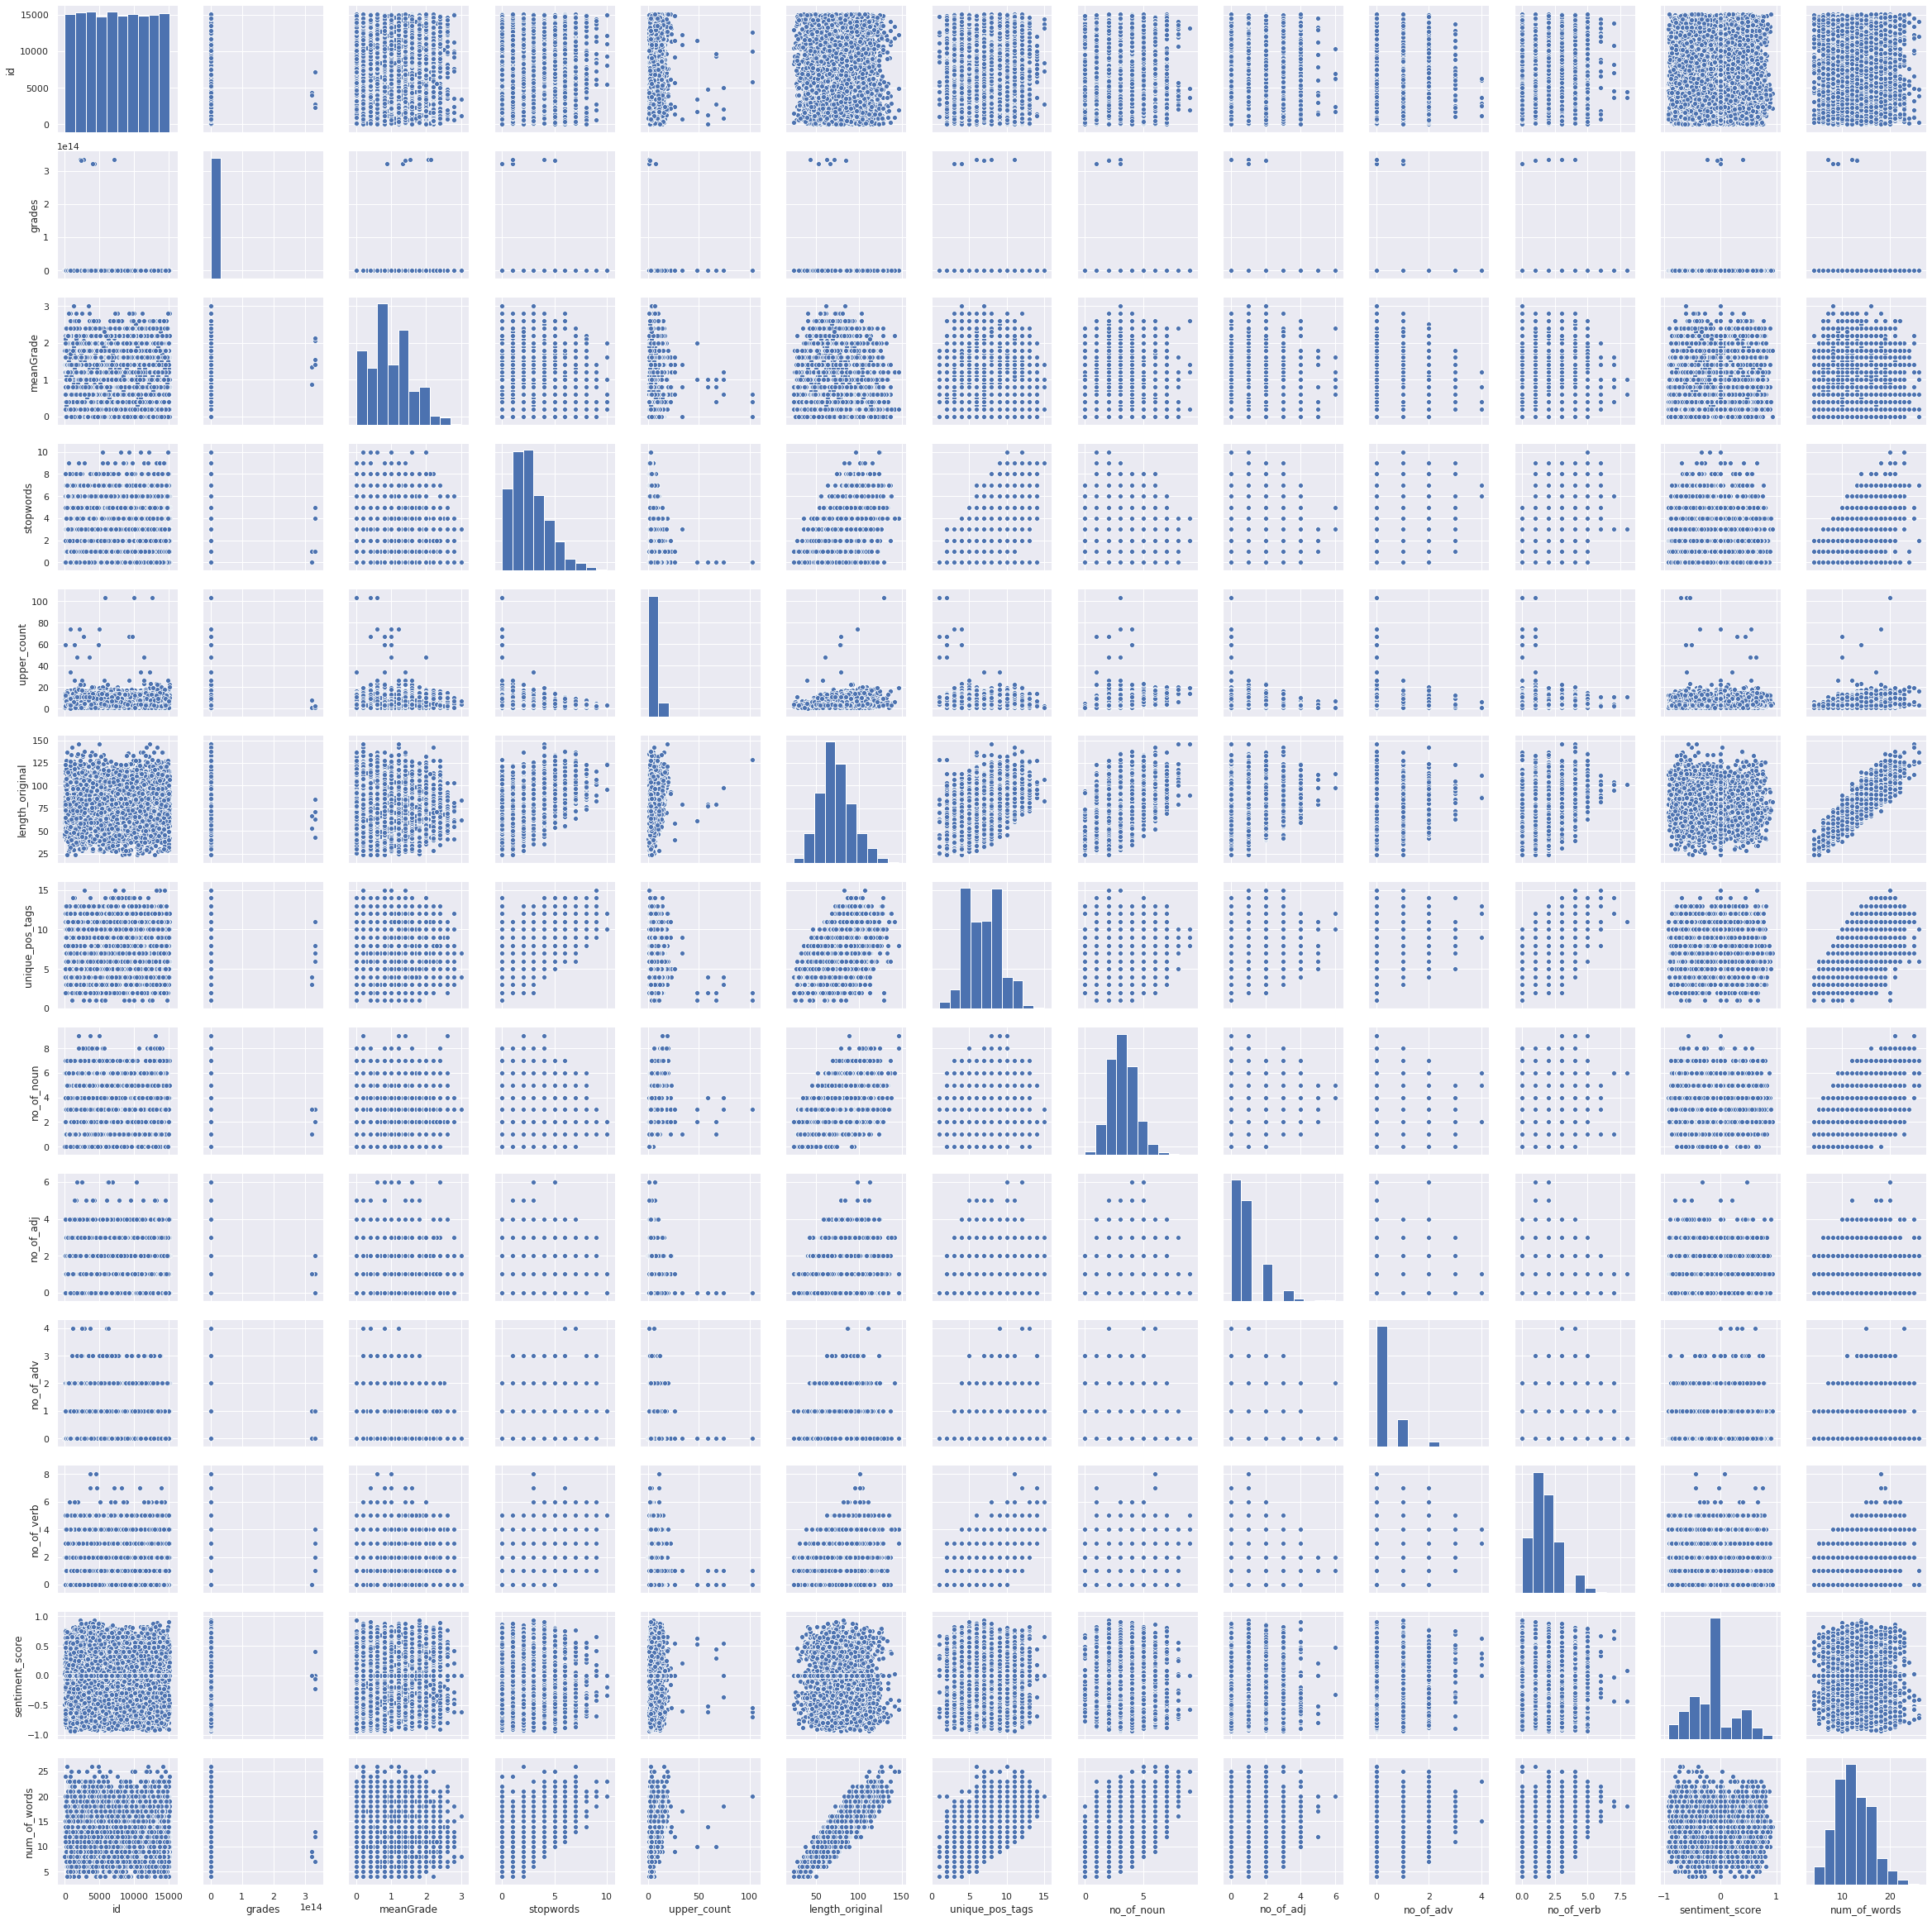

In [74]:
sns.pairplot(train_df)